<center>

*******************************************************************************************

<font size="4">
Wavelet Coherence Transform<br>
</font>

##### 7 September 2025

##### Juan Ignacio Mendoza Garay
*******************************************************************************************

</center>

##### INFORMATION:

* The Wavelet Coherence Transform (WCT) measures the time-frequency relationship between two periodic signals at different time-scales.
>
* Dependency:
    * [PyCWT](https://github.com/regeirk/pycwt)
>
* Tested with:
    * Python 3.11
    * Matlab 2024b
    * Windows 11
>
* References:
    * Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. *Bulletin of the American Meteorological society, 79*(1), 61-78.
    * Krieger, S., & Freij, N. (2024). *PyCWT: Wavelet spectral analysis in Python*. https://github.com/regeirk/pycwt
    * https://pycwt.readthedocs.io
>
* Instructions:
    * Ensure that the dependecies are installed.
    * Edit the values indicated with an arrow like this: <---
    * Run the program, close your eyes, and hope for the best.

*******************************************************************************************

In [1]:
import sys
import pycwt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

***
### Generate synthetic data

In [2]:
def supersine(argdict):
    '''
    Produce a sine wave with optional variables for distortion.
    Arg:
        wavargs = dict()
        Required values:
            wavargs['frequency']: scalar (Hz)
            wavargs['phase_shift']: scalar or scalar * numpy.pi
            wavargs['amplitude']: scalar
            wavargs['sampling_frequency']: scalar (Hz or fps)
            wavargs['length']: int (number of samples or frames)
        Optional values:
            wavargs['vertical_offset']: scalar
            wavargs['irregularity']: scalar in [0...1]
            wavargs['noise_strength']: scalar in [0...1]
    Returns:
        array
    '''
    from scipy.interpolate import CubicSpline

    f = argdict.get('frequency')
    ps = argdict.get('phase_shift')
    amp = argdict.get('amplitude')
    fps = argdict.get('sampling_frequency')
    l = argdict.get('length')
    v_offset = argdict.get('vertical_offset',0)
    irregularity = argdict.get('irregularity',0)
    noise_strength = argdict.get('noise_strength',0)
    noise_strength = noise_strength

    rangen = np.random.default_rng()
    t = np.arange(0, l)/fps
    y = np.sin(2*np.pi*f*t + ps/2)
    if irregularity:
        if irregularity >= 1:
            y = np.zeros(l)
        else:
            n_ran = int(np.ceil((l-2) * (1-irregularity)**2))
            if n_ran < 1: n_ran = 1
            ran_idx = np.sort(rangen.choice(np.arange(1,l), size=n_ran, replace=False))
            ip_x = np.insert(ran_idx, [0,n_ran], [0,l])
            ip_y = y[ran_idx]
            ip_y = ip_y - ip_y * rangen.random(size=ip_y.shape[0]) * irregularity**2
            ip_y = np.insert(ip_y, [0,n_ran], [0,0])
            ipf = CubicSpline(ip_x,ip_y)
            y = ipf(np.arange(l))
    noiz = rangen.uniform(-0.9,0.9,l)
    y = (y - (y * noiz * noise_strength ))
    y = (y * amp) / (np.max( [ abs(y.min()) , y.max() ] ) * 2)
    y = y + v_offset
    return y

In [3]:
def testdata(*args,**kwargs):
    '''
    Generate synthetic data for testing functions that measure synchronisation.
    Arguments can be the same keywords for function 'init_testdatavars',
    or a dictionary resulting from that function.
    If no arguments are given, default data will be produced with the function 'init_testdatavars'.
    Args:
        see help(init_testdatavars)
    Returns:
        N-D array with dimensions [points,axes,frames]
    '''
    if args:
        kwargs = args[0]

    if not kwargs:
        kwargs = init_testdatavars()

    if kwargs:
        fps = kwargs.get('fps')
        durations_sections = kwargs.get('durations_sections')
        total_duration = kwargs.get('total_duration')
        n_axes = testdata_vars['n_axes']
        n_points = testdata_vars['n_points']
        point_vars = kwargs.get('point_vars') # dim = [sections,points,axes,vars]
        # vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength

    test_data = np.empty((n_points,n_axes,total_duration)) # dim = [points,axes,frames]
    i_start_section = 0
    for i_s,s in enumerate(point_vars):
        n_frames = durations_sections[i_s] * fps
        i_end_section = i_start_section + n_frames
        for i_p,p in enumerate(s):
            for i_ax,ax in enumerate(p):
                wavargs = {}
                wavargs['frequency'] = ax[0]
                wavargs['phase_shift'] = ax[1]
                wavargs['amplitude'] = ax[2]
                wavargs['sampling_frequency'] = fps
                wavargs['length'] = n_frames
                wavargs['vertical_offset'] = ax[3]
                wavargs['irregularity']  = ax[4]
                wavargs['noise_strength'] = ax[5]
                test_data[i_p,i_ax,i_start_section:i_end_section] = supersine(wavargs)
        i_start_section = i_end_section
    return test_data

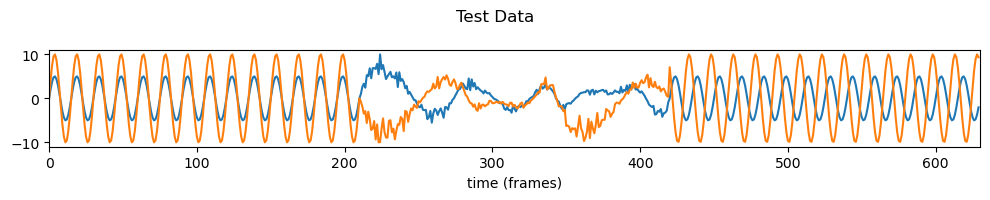

In [4]:
testdata_vars = { 'fps':30,'durations_sections':[7,7,7], 'n_points':2,'n_axes':1 }
testdata_vars['total_duration'] = sum(testdata_vars['durations_sections']) * testdata_vars['fps']
testdata_vars['point_vars'] = np.empty(( len(testdata_vars['durations_sections']),
                                         testdata_vars['n_points'], testdata_vars['n_axes'],6 ))

# vars = frequency, phase_shift, amplitude, vertical_offset, irregularity, noise_strength
# section 0:
testdata_vars['point_vars'][0,0,0] = 1, 0,   10, 0, 0, 0
testdata_vars['point_vars'][0,1,0] = 1, 0,   20, 0, 0, 0
# section 1:
testdata_vars['point_vars'][1,0,0] = 1, 0.2, 20, 0, 0.75, 0.5
testdata_vars['point_vars'][1,1,0] = 1, 0.7, 20, 0, 0.78, 0.5
# section 2:
testdata_vars['point_vars'][2,0,0] = 1, 0,         10, 0, 0, 0
testdata_vars['point_vars'][2,1,0] = 1, 3*np.pi/2, 20, 0, 0, 0

testdata_vars['point_vars'][[0,2],...,0] = 2 # <--- baseline frequency (Hz)

test_data_0 = testdata(testdata_vars)

plt.figure(figsize=(10,2))
for s in test_data_0[:,0,:]:
    plt.plot(s)
    plt.xlim((0,testdata_vars['total_duration']))
plt.xlabel('time (frames)')
plt.suptitle('Test Data')
plt.tight_layout();

Sections:
1. in synchrony, different amplitude
2. random oscillation
3. constant phase difference, different amplitude (same as 1)

***
### Wavelet Coherence

In [5]:
freq_minmax = [1,10] # <--- minimum and maximum frequency (Hz)
n_freqscales = 10    # <--- number of time scales (i.e., frequency bins)

min_freq_in = freq_minmax[0]
max_freq_in = freq_minmax[1]
dt = 1/testdata_vars['fps']
flambda = pycwt.Morlet().flambda()
s0 = 1/(flambda*max_freq_in)
J = n_freqscales - 1
dj = -np.log2( 1/flambda * min_freq_in * s0)/J

WCT, _, coi, freq_out, _ = pycwt.wct( test_data_0[0,0,:], test_data_0[1,0,:], dt, dj=dj, s0=s0, J=J,
                                      wavelet='morlet', normalize=False, sig=False )

In [6]:
def plot_wct(m, title):
    plt.figure(figsize=(10,4))

    plt.subplot(2,1,1)
    plt.imshow(m, aspect='auto')
    plt.title(title)
    yticks_loc,_ = plt.yticks()
    yticks_loc_new = yticks_loc
    yticks_loc_new = [int(i) for i in yticks_loc_new if ((i >= 0) and (i < n_freqscales))]
    yticks_lbl = [round(freq_out[i],1) for i in yticks_loc_new]
    plt.yticks(yticks_loc_new,yticks_lbl)
    plt.ylabel('frequency $(Hz)$')
    plt.xlim((0,testdata_vars['total_duration']))
    plt.xlabel('time (frames)')

    m_mean = np.nanmean(m,axis=0)
    plt.subplot(2,1,2)
    plt.plot(m_mean)
    plt.xlim((0,testdata_vars['total_duration']))
    plt.xlabel('time (frames)')
    plt.title('Mean '+title)
    plt.tight_layout()

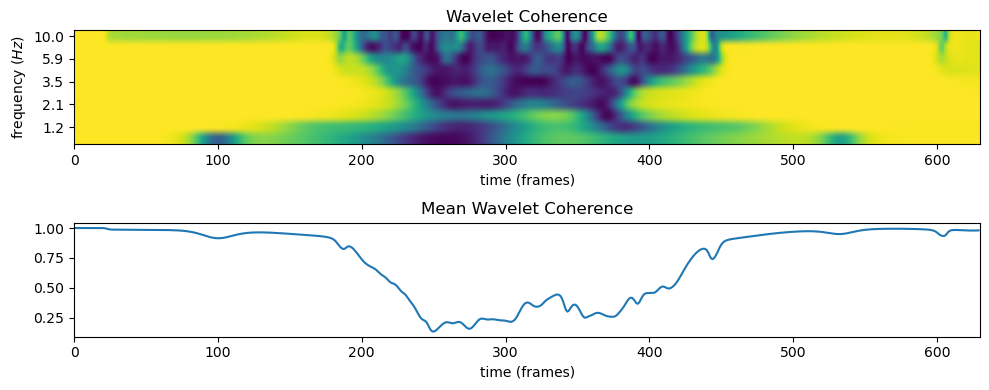

In [7]:
plot_wct(WCT, "Wavelet Coherence")

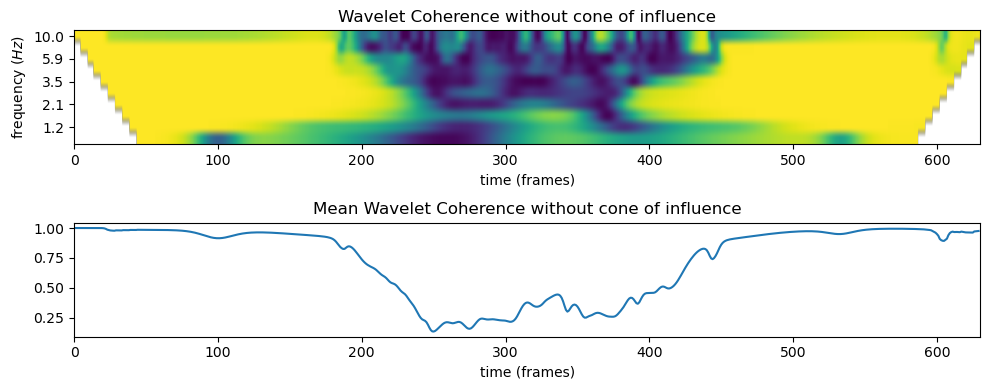

In [8]:
period = 1/freq_out
coi_rs = coi
coi_rs[ coi_rs > period[-1] ] = np.nan
coi_rs = (coi_rs/max(coi_rs)) * J
WCT_c = WCT.copy()
for i,t in enumerate(coi_rs):
    if np.isnan(t): break
    row = int(np.ceil(t))
    WCT_c[row:, i] = np.nan
    WCT_c[row:, -i] = np.nan
plot_wct(WCT_c, "Wavelet Coherence without cone of influence")